In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Roof Area Verification

### Group WB_rt analysis output by building_id 'CodEdifici'

In [3]:
data = gpd.read_file('pyqgis_wb_automatiser/bilbao_otxarkoaga_v2/00_wb_rt_analysis_bilbao_otxarkoaga_v2_segments.shp', encoding='utf-8') # Load the data

col_rename = {"AREA":"s_area", "SLOPE": 'slope',"FID": "segm_id", "BUILDING": "wb_build_id",
                "MAX_ELEV": "max_elev", "HILLSHADE": "hillshade","ASPECT": "aspect"}
data = data.rename(columns=col_rename) # Rename the columns

In [4]:
data['slope_rad'] = data.slope/180*np.pi # Convert the slope to radians
# Adjust the actual s_area for sloped roofs based on the slope and the actual horizontal projection of the roof s_area
data['s_area'] = data['s_area'] / np.cos(data['slope_rad']) 
group_data = data.groupby('build_id').agg({'s_area': 'sum', 'census_id': lambda x: x.unique()}).reset_index()
group_data = group_data.rename(columns={'s_area': 'r_area'})
group_data.to_csv('data/roof_area_group_wb_segments.csv', index=False)
group_data["census_id"] = group_data['census_id'].apply(lambda x: x[0])

In [15]:
group_data

,build_id,r_area,census_id
0,201302300411,124.973627,4802003005
1,201302300412,126.994182,4802003005
2,201303100211,502.449439,4802003003
3,201303100311,505.361189,4802003003
4,201303100411,491.195313,4802003003
...,...,...,...
323,201315300211,380.899448,4802003015
324,201315300411,329.834406,4802003015
325,201315300412,325.473306,4802003015
326,201315300511,333.484200,4802003015


### Join and Compate results with reference case

In [5]:
df_ref = pd.read_csv('BuildingStockCharacterization_Bilbao_Districts01&02&03.csv', sep=';',decimal=',')

# Ensure the 'CodEdifici' column in both dataframes is of the same type
group_data['build_id'] = group_data['build_id'].astype(str)
df_ref = df_ref.rename(columns={'CodEdifici': 'build_id'})
df_ref['build_id'] = df_ref['build_id'].astype(str)

# Join group_data and df_ref by column "CodEdifici"
data = pd.merge(group_data, df_ref, on='build_id', how='inner')

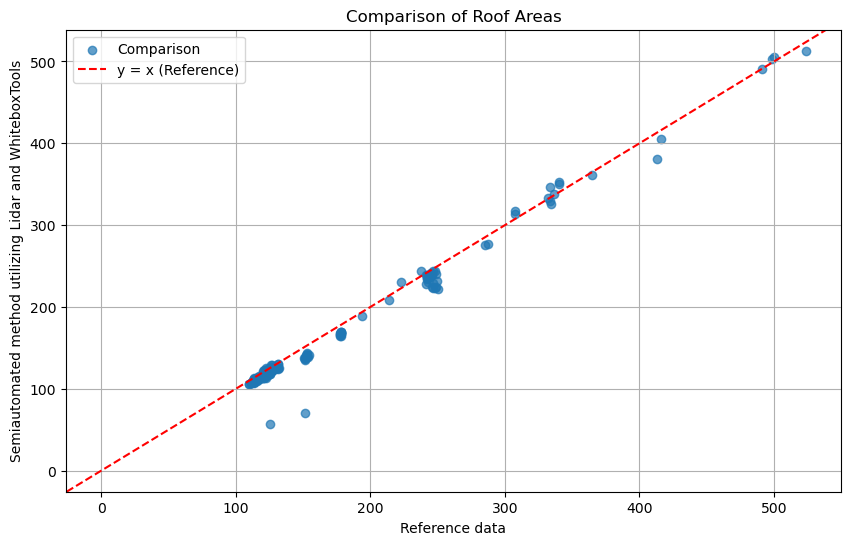

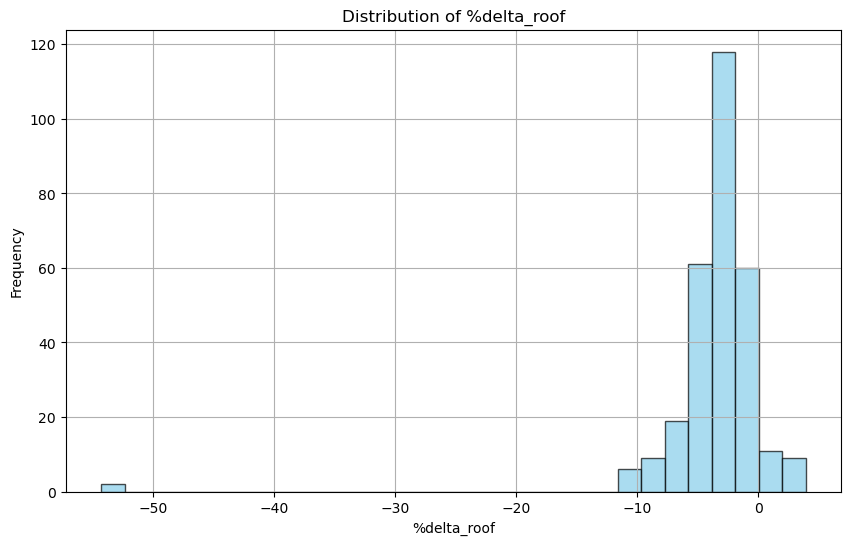

In [6]:
# Filter out rows with missing values in 'roof_s_area' or 'AreaCubier'
filtered_data = data.dropna(subset=['r_area', 'AreaCubier'])

# Calculate the '%delta_roof' column
filtered_data['%delta_roof'] = (filtered_data['r_area'] * 100 / filtered_data['AreaCubier']) - 100

# Create a scatter plot to visualize the comparison
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['AreaCubier'], filtered_data['r_area'], alpha=0.7, label='Comparison')
#plt.scatter(filtered_data['AreaCubier'], filtered_data['r_area'], alpha=0.7, label='Comparison', c=filtered_data['Ano_Constr'], cmap='viridis')
#plt.colorbar(label='Year of Construction')
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y = x (Reference)')
plt.title('Comparison of Roof Areas')
plt.xlabel('Reference data')
plt.ylabel('Semiautomated method utilizing Lidar and WhiteboxTools')
plt.legend()
plt.grid(True)
plt.show()

# Create a histogram of %delta_roof to visualize distribution of differences
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['%delta_roof'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of %delta_roof')
plt.xlabel('%delta_roof')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

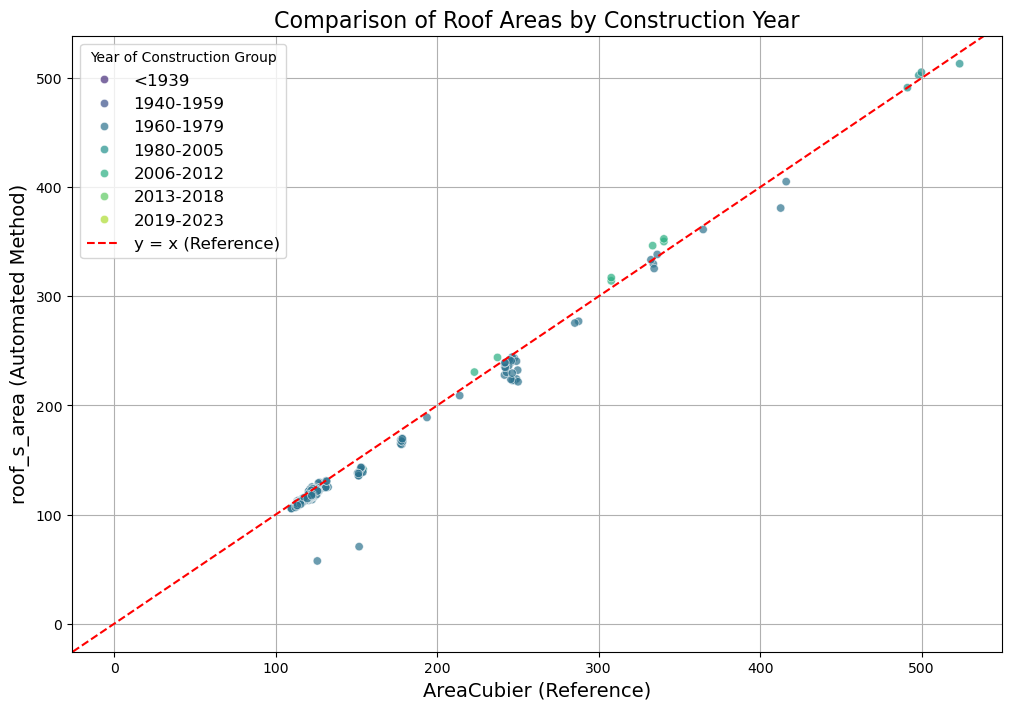

C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19156\948650338.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


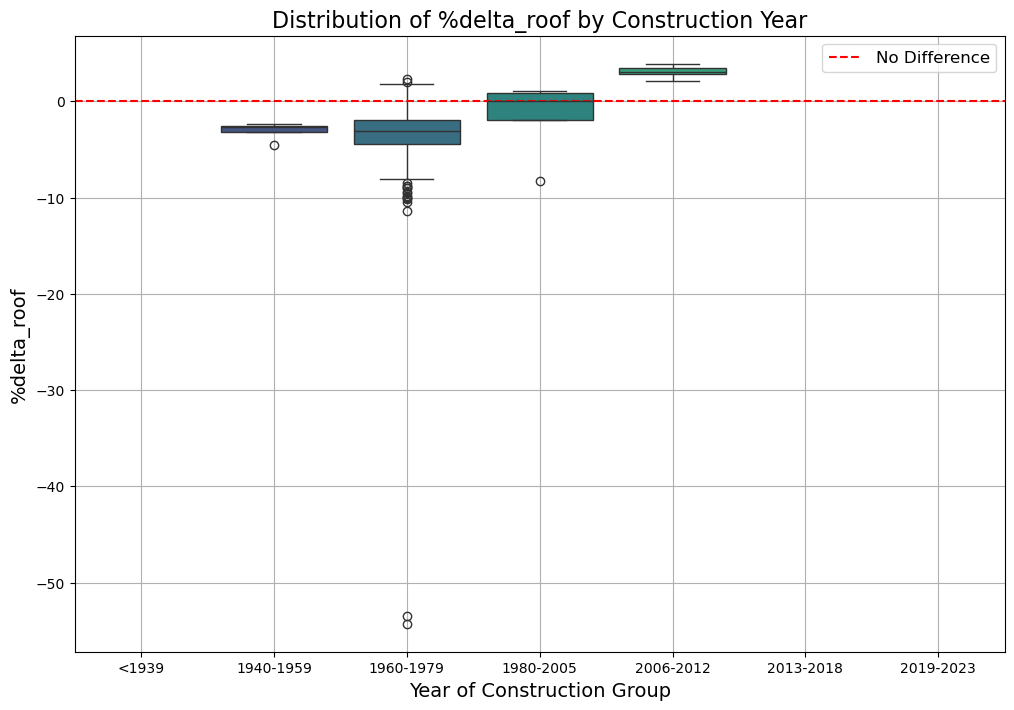

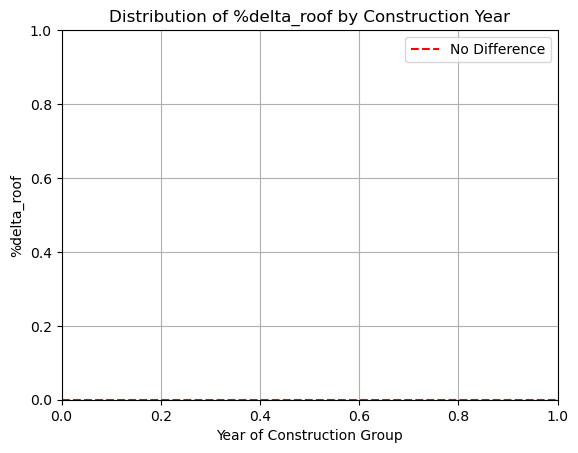

In [7]:
# Filter out rows with missing values in 'roof_s_area' or 'AreaCubier'
#file_path = 'data/03_footprint_subtracted_facades_and_s_v_volume_area.geojson'
#data = gpd.read_file(file_path)
#filtered_data = data.dropna(subset=['roof_s_area', 'AreaCubier'])
# Define the construction periods for Spanish building stock
constr_periods = {  # Define the construction periods
    '<1939': (0, 1939),
    '1940-1959': (1940, 1959),
    '1960-1979': (1960, 1979),
    '1980-2005': (1980, 2005),
    '2006-2012': (2006, 2012),
    '2013-2018': (2013, 2018),
    '2019-2023': (2019, 2023)
    }

# Calculate the '%delta_roof' column
filtered_data['%delta_roof'] = (filtered_data['r_area'] * 100 / filtered_data['AreaCubier']) - 100

# Define a range of years for grouping if needed
filtered_data['Ano_Constr_Group'] = pd.cut(
    filtered_data['Ano_Constr'], 
    bins=[0] + [end for start, end in constr_periods.values()], 
    labels=list(constr_periods.keys())
)

# Scatter plot with construction year as hue
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='AreaCubier',
    y='r_area',
    hue='Ano_Constr_Group',
    data=filtered_data,
    palette='viridis',
    alpha=0.7
)
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y = x (Reference)')
plt.title('Comparison of Roof Areas by Construction Year', fontsize=16)
plt.xlabel('AreaCubier (Reference)', fontsize=14)
plt.ylabel('roof_s_area (Automated Method)', fontsize=14)
plt.legend(title='Year of Construction Group', fontsize=12)
plt.grid(True)
plt.show()

# Boxplot for %delta_roof by construction year
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='Ano_Constr_Group',
    y='%delta_roof',
    data=filtered_data,
    palette='viridis'
)
plt.axhline(0, color='red', linestyle='--', label='No Difference')
plt.title('Distribution of %delta_roof by Construction Year', fontsize=16)
plt.xlabel('Year of Construction Group', fontsize=14)
plt.ylabel('%delta_roof', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()
plt.axhline(0, color='red', linestyle='--', label='No Difference')
plt.title('Distribution of %delta_roof by Construction Year')
plt.xlabel('Year of Construction Group')
plt.ylabel('%delta_roof')
plt.grid(True)
plt.legend()
plt.show()

In [41]:
filtered_data.to_csv("data/verification_rooftop_area_with_delta.csv", index=False)

### Facade Area Verification

In [8]:
"""Calculate %delta for facade per orientation"""
file_path = 'data/03_footprint_subtracted_facades_and_s_v_volume_area_filter_0.1.geojson'#03_footprint_subtracted_facades_and_s_v_volume_area.geojson'
data_facade = gpd.read_file(file_path)
#To data_facade join only those columns from df_ref that are not already in the data_facade
data= pd.merge(data_facade,df_ref[df_ref.columns.difference(data_facade.columns).tolist() + ['build_id']], on='build_id', how='inner')
data.columns

Index(['build_id', 'census_id', 'Codigo_Pol', 'Codigo_Par', 'building',
       'Numero_Alt', 'Ano_Constr', 'Ano_Rehabi', 'h_mean', 'h_stdev', 'h_min',
       'h_max', 'f_area', 'f_perimeter', 'n_floorsEstim', 'h_estim', 'len_N',
       'len_NW', 'len_E', 'len_SW', 'len_S', 'len_SE', 'len_W', 'len_NE',
       'neighboring_polygons', 'surface_area', 'volume', 's_v_ratio',
       'fa_area_N', 'fa_area_NE', 'fa_area_E', 'fa_area_SE', 'fa_area_S',
       'fa_area_SW', 'fa_area_W', 'fa_area_NW', 'geometry', 'AnoConsReh',
       'AreaCubier', 'Codigo_Cal', 'Codigo_Edi', 'Codigo_Mun', 'Codigo_Sub',
       'Codigo_Uso', 'DN_mean', 'DN_min', 'Duplicado_', 'HcatasVivi',
       'Hcatastro', 'Hmda', 'Infiltraci', 'NPlantasVi', 'NUMVIVIEND',
       'Numero_A_1', 'Numero_Por', 'Orden_Port', 'PerdVentil', 'PeriodoCon',
       'SumSupFaE', 'SumSupFaN', 'SumSupFaNE', 'SumSupFaNO', 'SumSupFaO',
       'SumSupFaS', 'SumSupFaSE', 'SumSupFaSO', 'SupMuroE', 'SupMuroN',
       'SupMuroNE', 'SupMuroNO', 'SupMu

In [9]:
"""Calculate %delta for facade per orientation"""
# Extract relevant columns for calculated values (fa_area_*) and reference values (SumSupFa*)
facade_columns = [col for col in data.columns if col.startswith('fa_area_') or col.startswith('SumSupFa')]

columns_to_save = ['build_id','census_id', "AreaCubier",'Ano_Constr', 'Ano_Rehabi','h_mean',
       'h_stdev', 'h_min', 'h_max', 'f_area','f_perimeter', 'surface_area', 'volume', 's_v_ratio', 'geometry']
# Filter the dataset to only these columns
facade_data = data[facade_columns+columns_to_save]

# filter rows with nan values
facade_data = facade_data.dropna()

# Calculate percentage delta for each orientation
orientations = {
    'N': ('fa_area_N', 'SumSupFaN'),
    'NE': ('fa_area_NE', 'SumSupFaNE'),
    'E': ('fa_area_E', 'SumSupFaE'),
    'SE': ('fa_area_SE', 'SumSupFaSE'),
    'S': ('fa_area_S', 'SumSupFaS'),
    'SW': ('fa_area_SW', 'SumSupFaSO'),  # Note: SO corresponds to SW
    'NW': ('fa_area_NW', 'SumSupFaNO'),  # Note: NO corresponds to NW
    'W': ('fa_area_W', 'SumSupFaO')      # Note: O corresponds to W
}
colums_ref_case = ['SumSupFaN','SumSupFaNE','SumSupFaE','SumSupFaSE','SumSupFaS','SumSupFaSO','SumSupFaNO','SumSupFaO']
colums_calc_case = ['fa_area_N','fa_area_NE','fa_area_E','fa_area_SE','fa_area_S','fa_area_SW','fa_area_NW','fa_area_W']

# Set values lower than 5 to 0
facade_data[colums_ref_case] = facade_data[colums_ref_case].applymap(lambda x: 0 if x < 5 else x)
facade_data[colums_calc_case] = facade_data[colums_calc_case].applymap(lambda x: 0 if x < 5 else x)


# Compute the % delta for each orientation
for orientation, (calc_col, ref_col) in orientations.items():
    if calc_col in facade_data.columns and ref_col in facade_data.columns:
        facade_data[f'%delta_fa_{orientation}'] = (
            (facade_data[calc_col] * 100 / facade_data[ref_col]) - 100
        )
        facade_data["Total_SumSupFa"] = facade_data[[col for col in facade_data.columns if col.startswith('SumSupFa')]].sum(axis=1)
        facade_data["Total_fa_area"] = facade_data[[col for col in facade_data.columns if col.startswith('fa_area_')]].sum(axis=1)
        facade_data["%delta_fa_Total"] = (facade_data["Total_fa_area"] * 100 / facade_data["Total_SumSupFa"]) - 100

        # Round the calculated %delta values to 4 decimal places
        for col in facade_data.columns:
            if col.startswith('%delta_'):
                facade_data[col] = facade_data[col].round(4)

# Define construction year groups in the original dataset
facade_data['Ano_Constr_Group'] = pd.cut(
    data['Ano_Constr'],
    bins=[0] + [end for start, end in constr_periods.values()], 
    labels=list(constr_periods.keys())
    #bins=[0, 1950, 1970, 1990, 2010, 2030],
    #labels=['<1950', '1950-1970', '1970-1990', '1990-2010', '>2010']
)

# Save the updated data to a new CSV file
#facade_data.to_csv('data/03_footprint_subtracted_facades_and_s_v_volume_area_with deltas.csv', index=False)
#facade_data.to_file('data/03_footprint_subtracted_facades_and_s_v_volume_area_with deltas.geojson', driver='GeoJSON')

C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19156\1891768138.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19156\1891768138.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19156\1891768138.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19156\1891768138.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

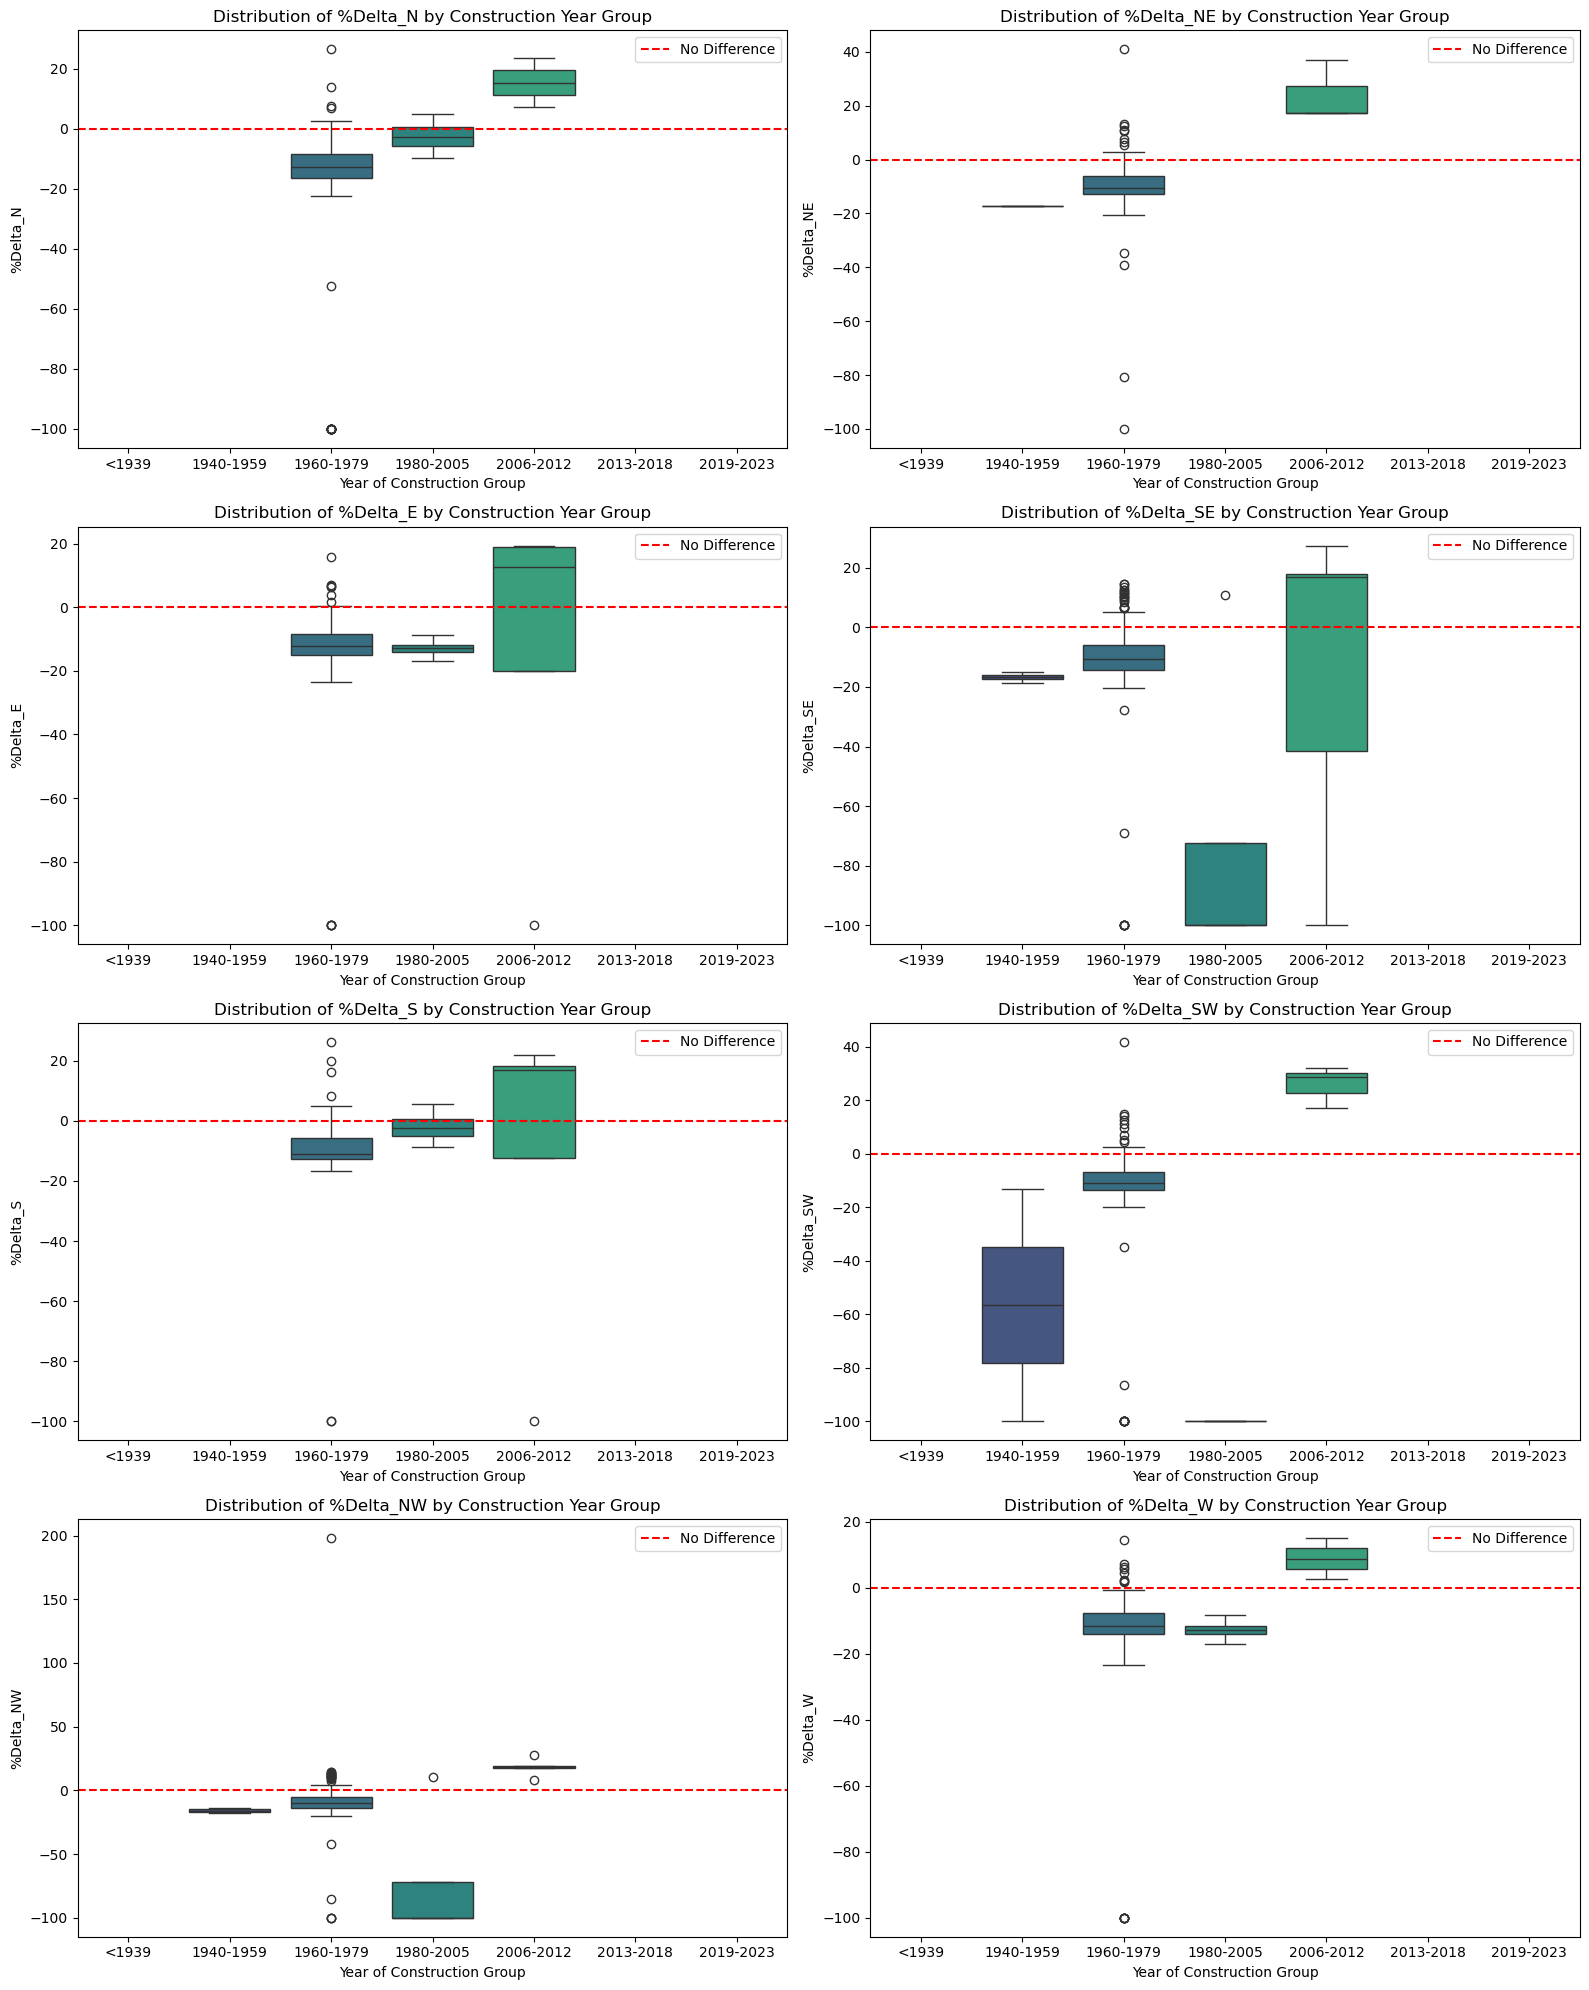

In [10]:
# PLOT THE DISTRIBUTION OF %DELTA FOR EACH ORIENTATION BY CONSTRUCTION YEAR GROUP

# Prepare a filtered dataset with the necessary columns
#filtered_data = data.copy()

# Ensure the filtered data contains the relevant columns for the analysis
required_columns = ['Ano_Constr_Group'] + [f'%delta_fa_{orientation}' for orientation in orientations.keys()]
#filtered_data = filtered_data[required_columns].dropna()

# Display the structure of filtered_data to confirm all necessary columns are present
#import ace_tools as tools; tools.display_dataframe_to_user(name="Filtered Data for Boxplot Analysis", dataframe=filtered_data)

# Create a grid of boxplots for each orientation
orientations_delta_columns = [f'%delta_fa_{orientation}' for orientation in orientations.keys()]
num_orientations = len(orientations_delta_columns)
#filter to exclude columns with fa_area_{orientation} less that 5m2


# Set up the grid layout
fig, axes = plt.subplots(
    nrows=(num_orientations // 2) + (num_orientations % 2),
    ncols=2,
    figsize=(16, 20)
)
axes = axes.flatten()

# Plot each orientation
for idx, orientation in enumerate(orientations.keys()):
    column = f'%delta_fa_{orientation}'
    if column in facade_data.columns:
        sns.boxplot(
            x='Ano_Constr_Group',
            y=column,
            data=facade_data,
            ax=axes[idx],
            palette='viridis'
        )
        axes[idx].axhline(0, color='red', linestyle='--', label='No Difference')
        axes[idx].set_title(f'Distribution of %Delta_{orientation} by Construction Year Group')
        axes[idx].set_xlabel('Year of Construction Group')
        axes[idx].set_ylabel(f'%Delta_{orientation}')
        axes[idx].legend()
    else:
        axes[idx].axis('off')  # Hide unused subplots

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19156\1524451555.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


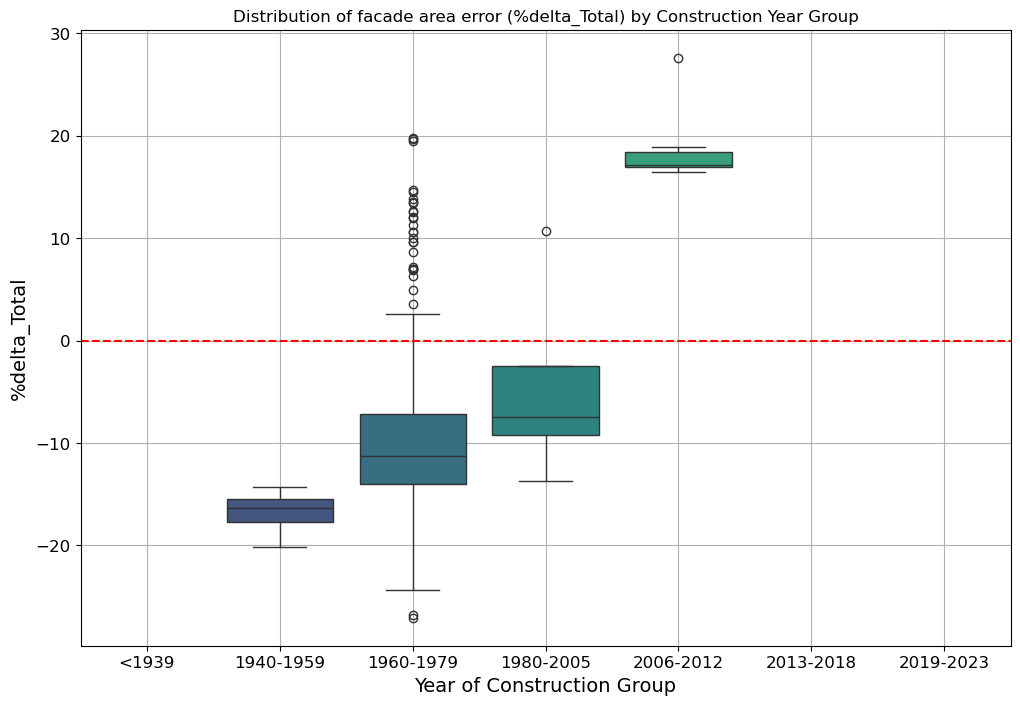

In [11]:
# Plot the distribution of %delta_fa_Total by construction year group
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='Ano_Constr_Group',
    y='%delta_fa_Total',
    data=facade_data,
    palette='viridis'
)
plt.axhline(0, color='red', linestyle='--', label='No Difference')

plt.ylabel('%delta_Total', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of facade area error (%delta_Total) by Construction Year Group')
plt.xlabel('Year of Construction Group', fontsize=14)
plt.grid(True)

In [46]:
# Convert the categorical data type to string before saving
facade_data['Ano_Constr_Group'] = facade_data['Ano_Constr_Group'].astype(str)

# Save the files
facade_data.to_csv('data/03_footprint_subtracted_facades_and_s_v_volume_area_with_deltas.csv', index=False)
facade_data.to_file('data/03_footprint_subtracted_facades_and_s_v_volume_area_with_deltas.geojson', driver='GeoJSON')

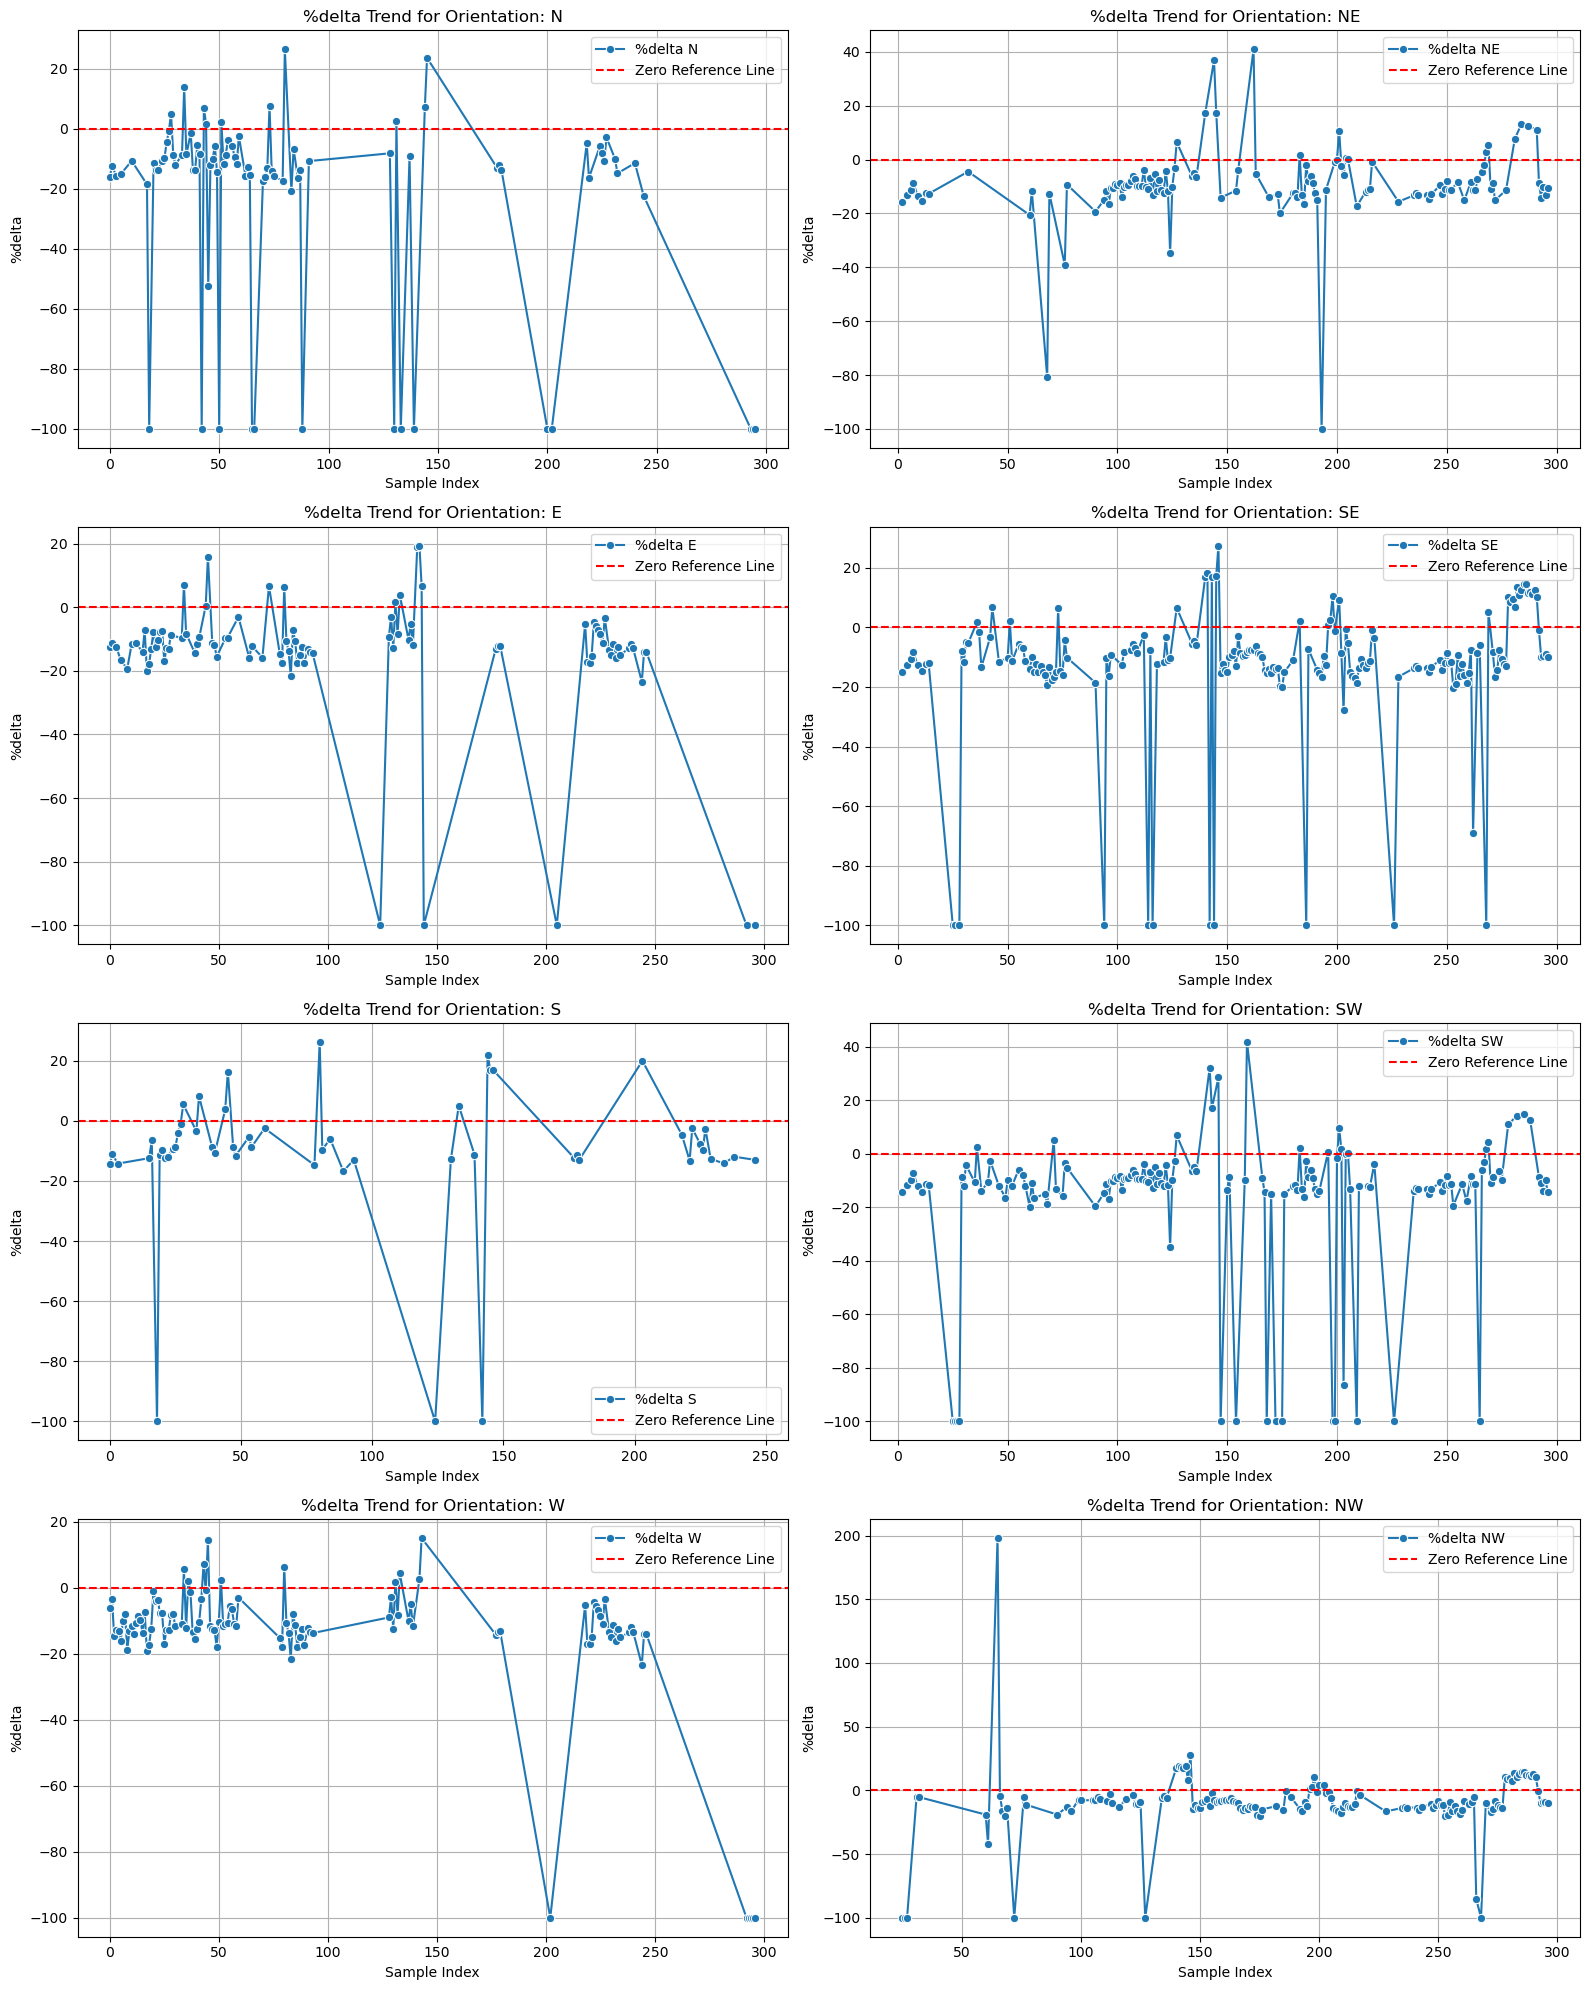

" \n# Plot %delta trends for each orientation SEPARATELY\nfor orientation, column in zip(orientations, delta_columns):\n    plt.figure(figsize=(10, 6))\n    plt.plot(facade_data[column], marker='o', linestyle='-', label=f'%delta {orientation}')\n    plt.title(f'%delta Trend for Orientation: {orientation}')\n    plt.xlabel('Sample Index')\n    plt.ylabel('%delta')\n    plt.axhline(0, color='red', linestyle='--', label='Zero Reference Line')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n"

In [12]:
# PLOT THE %DELTA TRENDS FOR EACH ORIENTATION

# Extract %delta columns and their corresponding orientations
orientations = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
delta_columns = [f'%delta_fa_{orientation}' for orientation in orientations]

# Plot %delta trends for each orientation as subplots
# Set up the grid layout
fig, axes = plt.subplots(
    nrows=(len(orientations) // 2) + (len(orientations) % 2),
    ncols=2,
    figsize=(16, 20)
)
axes = axes.flatten()

# Plot each orientation
for idx, (orientation, column) in enumerate(zip(orientations, delta_columns)):
    sns.lineplot(
        x=facade_data.index,
        y=facade_data[column],
        marker='o',
        linestyle='-',
        ax=axes[idx],
        label=f'%delta {orientation}'
    )
    axes[idx].axhline(0, color='red', linestyle='--', label='Zero Reference Line')
    axes[idx].set_title(f'%delta Trend for Orientation: {orientation}')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('%delta')
    axes[idx].legend()
    axes[idx].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

""" 
# Plot %delta trends for each orientation SEPARATELY
for orientation, column in zip(orientations, delta_columns):
    plt.figure(figsize=(10, 6))
    plt.plot(facade_data[column], marker='o', linestyle='-', label=f'%delta {orientation}')
    plt.title(f'%delta Trend for Orientation: {orientation}')
    plt.xlabel('Sample Index')
    plt.ylabel('%delta')
    plt.axhline(0, color='red', linestyle='--', label='Zero Reference Line')
    plt.legend()
    plt.grid(True)
    plt.show()
"""

### Opening Area Verification
 W2Wall ratio estimation based on Reference case of Grand Bilbao (https://doi.org/10.3390/su16020652)

In [71]:
#import pandas as pd
data = pd.read_csv("BuildingStockCharacterization_Bilbao_Districts01&02&03.csv", sep=";", decimal=",")
# Define the construction periods for Spanish building stock
constr_periods = {  # Define the construction periods
    '<1939': (0, 1939),
    '1940-1959': (1940, 1959),
    '1960-1979': (1960, 1979),
    '1980-2005': (1980, 2005),
    '2006-2012': (2006, 2012),
    '2013-2018': (2013, 2018),
    '2019-2023': (2019, 2023)
    }
orientations_matching = {'N':'N', 'NE':'NE', 'E':'E' , 'SE':'SE', 'S':'S', 'SW':'SO', 'W':'O', 'NW':'NO'}
# Note: SO corresponds to SW
# Note: NO corresponds to NW
# Note: O corresponds to W

# Calculate the w2w ratios for each orientation
for key, value in orientations_matching.items():
    data[f'w2wall_{key}'] = data[f'SupVenta{value}'] / data[f'SumSupFa{value}']

In [72]:
df_average_w2wall = pd.DataFrame(columns=['Period', 'Orientation', 'Average_w2wall'])
# calculate average w2wall ratio for each building period of construction and orientation
for period, (start, end) in constr_periods.items():
    period_data = data[(data['Ano_Constr'] >= start) & (data['Ano_Constr'] <= end)]
    for key, value in orientations_matching.items():
        mean_ratio = period_data[f'w2wall_{key}'].dropna().mean()
        #print(f'Average w2wall ratio for period {period} and orientation {key}: {mean_ratio:.4f}')
        # Append the results to the dictionary
        df_average_w2wall = pd.concat([df_average_w2wall, pd.DataFrame({
            'Period': [period],
            'Orientation': [key],
            'Average_w2wall': [mean_ratio]
        })], ignore_index=True)

# df_average_w2wall but value of orientation as column
df_average_w2wall = df_average_w2wall.pivot(index='Period', columns='Orientation', values='Average_w2wall')

In [73]:
df_average_w2wall

Orientation,E,N,NE,NW,S,SE,SW,W
Period,,,,,,,,
1940-1959,0.240132,0.240117,0.240188,0.240062,0.240060,0.239976,0.240003,0.239375
1960-1979,0.240058,0.240132,0.240035,0.240067,0.240166,0.240091,0.240040,0.240433
1980-2005,0.240086,0.240033,0.240016,0.239977,0.240010,0.239996,0.240018,0.240002
2006-2012,0.240909,0.240027,0.240073,0.240017,0.240015,0.240073,0.240288,0.239786
2013-2018,0.239550,0.240084,0.240002,0.240000,0.240456,0.240552,0.240000,0.240417
2019-2023,0.239999,0.239997,0.240058,0.240012,0.240009,0.240005,0.240026,0.240004
<1939,0.239837,0.240004,0.240275,0.239878,0.239564,0.240124,0.239853,0.240129


In [74]:
#Put average w2wall ratios for each orientation depending on df_average_w2wall age of construction
facade_data["Tot_w2wall"] = 0.24
facade_data["Tot_window_area"] = facade_data["Total_fa_area"] * facade_data["Tot_w2wall"]

In [75]:
windows_columns = [col for col in data.columns if col.startswith('SupVenta')]
# Ensure the 'CodEdifici' column in both dataframes is of the same type
facade_data['build_id'] = facade_data['build_id'].astype(str)
data = data.rename(columns={'CodEdifici': 'build_id'})
data['build_id'] = data['build_id'].astype(str)

facade_data = pd.merge(facade_data, data[windows_columns+['build_id']], on='build_id', how='inner')
facade_data["SumSupVenta"] = facade_data[[col for col in facade_data.columns if col.startswith('SupVenta')]].sum(axis=1)

C:\Users\oleksandr.husiev\AppData\Local\Temp\ipykernel_19740\3075937327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


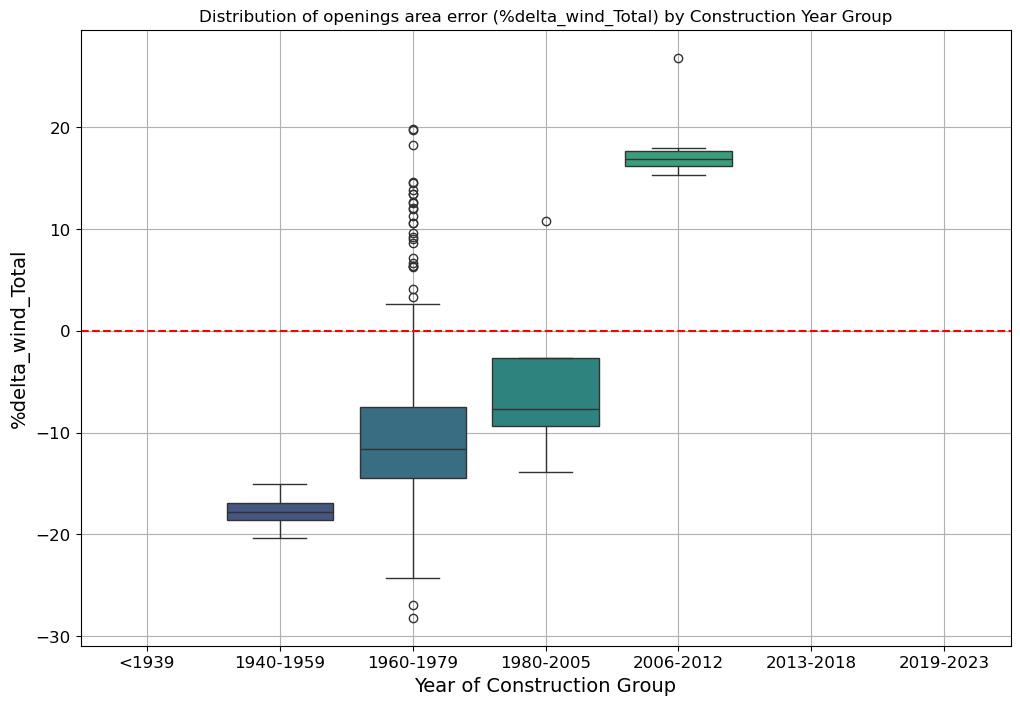

In [76]:
facade_data['%delta_wind_Total'] = (facade_data['Tot_window_area'] * 100 / facade_data['SumSupVenta']) - 100

# Plot the distribution of %delta_wind_area by construction year group
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='Ano_Constr_Group',
    y='%delta_wind_Total',
    data=facade_data,
    palette='viridis'
)
plt.axhline(0, color='red', linestyle='--', label='No Difference')

plt.ylabel('%delta_wind_Total', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of openings area error (%delta_wind_Total) by Construction Year Group')
plt.xlabel('Year of Construction Group', fontsize=14)
plt.grid(True)

In [77]:
facade_data[['%delta_fa_Total', '%delta_wind_Total']].describe()


,%delta_fa_Total,%delta_wind_Total
count,297.000000,297.000000
mean,-8.580934,-8.983586
std,9.262349,9.306306
min,-27.052100,-28.186789
25%,-14.031200,-14.509212
50%,-11.153900,-11.385154
75%,-6.154500,-6.530839
max,27.602600,26.814410


In [79]:
facade_data["Ano_Constr_Group"]=facade_data["Ano_Constr_Group"].astype(str)

In [80]:
# Save to file
facade_data.to_file('data/03_footprint_subtracted_facades_and_s_v_volume_area_with_deltas.geojson', driver='GeoJSON')
facade_data.to_csv('data/03_footprint_subtracted_facades_and_s_v_volume_area_with_deltas.csv', index=False)